In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import seaborn as sns
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

85
2928


/home/vollrath/.local/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


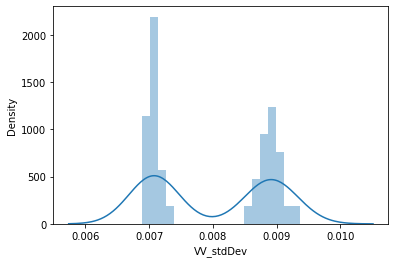

In [2]:
gdf = gpd.read_file('/home/vollrath/Indonesia_sm/gdf_s1_aux.gpkg')
len(gdf.station.unique())
print(len(gdf[gdf.station == 'BRG_150611_02']))
print(len(gdf))
#ax = sns.distplot(gdf['VV_stdDev'])
ax = sns.distplot(gdf[gdf.station == 'BRG_150611_02']['VV_stdDev'], bins=20)


In [9]:
stations = gpd.read_file('/home/vollrath/Indonesia_sm/stations_pix_corr.shp')

station_trusted = [
    'BRG_621103_05',
    'BRG_621103_04',
    'BRG_621103_01',
    'BRG_621103_02',
    'BRG_621103_06',
    'BRG_621103_03'
]
stat_trusted = [
'BRG_150706_01',
'BRG_150709_01',
'BRG_150710_01',
'BRG_150710_03',
'BRG_610207_01',
'BRG_610207_02',
'BRG_610216_01',
'BRG_611203_01',
'BRG_611209_01',
'BRG_621101_02',
'BRG_621103_01',
'BRG_621103_02',
'BRG_621103_03',
'BRG_621103_04',
'BRG_621103_05',
'BRG_621103_06',
'BRG_621105_03',
'BRG_621107_03',
'BRG_621107_05',
'BRG_621107_06',
'BRG_621107_07',
'BRG_621108_01',
'BRG_910111_01',
'kalbar1',
'kalteng1'
]

stat_trusted = ['BRG_621103_02', 'kalteng1', 'BRG_621103_01', 'BRG_621103_06',
       'BRG_621107_03', 'BRG_621107_06', 'BRG_150710_01', 'BRG_621107_05',
       'BRG_621103_05', 'BRG_150710_03', 'BRG_621103_04', 'BRG_610207_01',
       'BRG_621108_01', 'BRG_610216_01', 'BRG_910111_01', 'BRG_621105_03']

stat_high = stations.stasiun[(stations['corr_gwl'] >= 0.5)]
stat_med = stations.stasiun[(stations['corr_gwl'] < 0.5) & (stations['corr_gwl'] >= 0.3)]
stat_low = stations.stasiun[(stations['corr_gwl'] < 0.3)] 
len(stat_high)

54

In [23]:
bandlist = [
     #'orbit_direction',
     'VV', 'VH', 'VVVH_ratio', 'angle', 'LIA', #'layover', 'shadow', 'no_data_mask', 
     'precipitation', 'prec_3', 'prec_7', 'prec_30', 
     #'gldas_mean', 'gldas_stddev',
     'sm_1',  'sm_3', 'sm_7', 'sm_30',
     'elevation', 'aspect', 'slope', 
     'landcover',
     'kVV_mean', 'kVV_stdDev', 
     'kVV_p5', 'kVV_p95',
     'kVH_mean', 'kVH_stdDev', 
     'kVH_p5', 'kVH_p95', 
     'VV_mean', 'VV_stdDev', 
     'VV_p5', 'VV_p95', 
     'VH_mean', 'VH_stdDev', 
     'VH_p5', 'VH_p95'
    ]

#X = gdf_high[bandlist]
#y = gdf_high['SM_rata']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
gdf_high = gdf[gdf.station.isin(stat_trusted)].copy()

for i, station in enumerate(gdf_high.station.unique()):

    # create a df for training without the station
    gdf_train = gdf_high[gdf_high.station != station]
    
    # create a df for test of the station
    gdf_test = gdf_high[gdf_high.station == station]
    print(len(gdf_high), len(gdf_train), len(gdf_test))
    
    X_train, X_test = gdf_train[bandlist], gdf_test[bandlist]
    y_train, y_test = gdf_train['GWL_rata'], gdf_test['GWL_rata']
    
    regr = RandomForestRegressor(n_estimators=250, min_samples_leaf=1, random_state=42, oob_score=True, criterion='mse')
    regr.fit(X_train, y_train)
    y_pred_test = regr.predict(X_test)
    y_pred_train = regr.predict(X_train)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    print(station, r2_train, r2_test, mse_train, mse_test, y_train.max(), y_train.min(), y_test.mean(), y_test.std())
    d = {}
    d[station] = [len(gdf_train), len(gdf_test), r2_train, r2_test, mse_train, mse_test, y_test.mean(), y_test.std()]
    if i == 0:
        df = pd.DataFrame.from_dict(d, orient='index')
    else: 
        df = pd.concat([df, pd.DataFrame.from_dict(d, orient='index')])
        

712 684 28
kalteng1 0.9812698422641207 0.8727696114000949 0.05622579645849219 0.12488924148792237 0.289 -2.35 -0.42042857142857143 0.35655516726249714
712 673 39
BRG_621103_02 0.9814956028598009 0.8234769094664967 0.056379253312941253 0.1107231592831465 0.289 -2.35 -0.33351282051282044 0.26697968302306924
712 673 39
BRG_621103_04 0.9806915832062314 0.6727951468541454 0.05709991375141473 0.18150950603403102 0.289 -2.35 -0.27351282051282044 0.32146227345111844
712 673 39
BRG_621103_01 0.9818504206917475 0.8058055346014932 0.05588209098803155 0.11548629626774339 0.289 -2.35 -0.3508974358974359 0.26549266962541795
712 675 37
BRG_621108_01 0.9805259698655592 0.5617335574795997 0.0570085566935739 0.2444734991529923 0.289 -2.35 -0.6307027027027027 0.37437969918140485
712 635 77
BRG_910111_01 0.980551294937315 0.42704964908528564 0.053478356066818604 0.3868862401659097 0.289 -2.35 -0.7045844155844155 0.5144739098967571
712 642 70
BRG_150710_01 0.9806968458033164 0.6513707882426567 0.0582136703

In [25]:
df.columns = ['samples_train', 'samples_test', 'r2train', 'r2test', 'rmse2train', 'rmse2test', 'test_mean_sm', 'test_sd_sm']
df = df.sort_values('r2test', ascending=False)

In [26]:
df

,samples_train,samples_test,r2train,r2test,rmse2train,rmse2test,test_mean_sm,test_sd_sm
BRG_621107_06,675,37,0.980649,0.907861,0.056937,0.115082,-0.568486,0.384357
kalteng1,684,28,0.981270,0.872770,0.056226,0.124889,-0.420429,0.356555
BRG_621103_02,673,39,0.981496,0.823477,0.056379,0.110723,-0.333513,0.266980
BRG_621103_01,673,39,0.981850,0.805806,0.055882,0.115486,-0.350897,0.265493
BRG_621103_06,676,36,0.980824,0.749208,0.057447,0.106500,-0.296056,0.215679
BRG_150710_03,625,87,0.978931,0.741005,0.060905,0.128145,-0.269920,0.253260
BRG_621107_05,683,29,0.981773,0.702758,0.055250,0.169709,-0.692552,0.316790
BRG_621103_04,673,39,0.980692,0.672795,0.057100,0.181510,-0.273513,0.321462
BRG_150710_01,642,70,0.980697,0.651371,0.058214,0.172193,-0.397114,0.293737
BRG_621108_01,675,37,0.980526,0.561734,0.057009,0.244473,-0.630703,0.374380


In [16]:
from pandas.plotting import table
from matplotlib import pylab as plt

In [14]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, df)  # where df is your data frame

plt.savefig('mytable.png')

NameError: name 'plt' is not defined

In [18]:
import seaborn as sns
plt.figure(figsize=(20,20)) 
sns.heatmap(df['r2test'], annot=True)

IndexError: Inconsistent shape between the condition and the input (got (16, 1) and (16,))

<Figure size 1440x1440 with 0 Axes>

In [ ]:
df